In [1]:
%matplotlib inline

import captest as pvc
from bokeh.io import output_notebook, show

output_notebook()

Loading BokehJS ...

# Loading Measured and Simulated Data

CapData objects are used to load simulated (PVsyst data) and measured data from a DAS/SCADA system.  

The load_data method by default attempts to infer the type of measurement in each column and the type of sensor in each column.  For example, a measurment from a ambient temperature sensor would be categorized as 'temp-amb-'.  A dictionary which tranlates from the column titles in the input file and the inferred type is produced, which can be used to aggregate measurements from instruments of the same type and access individual columns of data without renaming columns.

A manual step is required to set which inferred measurement type is the correct one for the regression variables. The set_reg_trans method is used to set this relationship.

In [2]:
das = pvc.CapData()

In [3]:
das.load_data(fname='example_meas_data.csv')

In [4]:
das.trans

{'index--': ['index'],
 'irr-ghi-pyran': ['met1 ghi_pyranometer', 'met2 ghi_pyranometer'],
 'irr-poa-pyran': ['met1 poa_pyranometer', 'met2 poa_pyranometer'],
 'irr-poa-ref_cell': ['met1 poa_refcell', 'met2 poa_refcell'],
 'real_pwr-inv-': ['inv1 power',
  'inv2 power',
  'inv3 power',
  'inv4 power',
  'inv5 power',
  'inv6 power',
  'inv7 power',
  'inv8 power'],
 'real_pwr-mtr-': ['meter power'],
 'temp-amb-': ['met1 amb_temp', 'met2 amb_temp'],
 'temp-mod-': ['met1 mod_temp1',
  'met1 mod_temp2',
  'met2 mod_temp1',
  'met2 mod_temp2'],
 'wind-valuesError--': ['met1 windspeed', 'met2 windspeed']}

In [5]:
das.set_reg_trans(power='real_pwr-mtr-', poa='irr-poa-ref_cell', t_amb='temp-amb-', w_vel='wind-valuesError--')

The plot method of the CapData object creates a group of time series plots that are useful for performing an initial visual inspection of the imported data.

The plots are structured around the translation dictionary grouping the columns of measurements to the types of measurements.  A single plot is generated for each different type of data and each column within that measurement type is plotted as a separate series on the plot.  In this example there are two different weather stations, which each have pyranometers measuring plane of array and global horizontal irradiance. This arrangment of sensors results in two plots of irradiance measurments: one for global horizontal irradiance and one for plane of array irradiance.

In [6]:
das.plot(marker='line')

In [7]:
sim = pvc.CapData()

In [8]:
sim.load_data(load_pvsyst=True)

Skipped file: example_meas_data.csv
Read: pvsyst_example_HourlyRes_2.CSV


In [9]:
sim.trans

{'--': ['IL Pmax', 'IL Pmin', 'IL Vmax', 'IL Vmin', 'TArray'],
 '-inv-': ['EOutInv'],
 'index--': ['index'],
 'irr-ghi-': ['GlobHor', 'GlobInc'],
 'real_pwr--': ['E_Grid'],
 'shade--': ['FShdBm'],
 'temp-amb-': ['TAmb'],
 'wind--': ['WindVel']}

In [10]:
sim.drop_cols(['GlobHor'])

In [11]:
sim.set_reg_trans(power='real_pwr--', poa='irr-ghi-', t_amb='temp-amb-', w_vel='wind--')

In [12]:
# sim.plot()

# Performing Capacity Test

The CapTest object provides a framework that facilitates performing steps of a capacity test following the ASTM standard. Methods of the a CapTest object provide convenient ways to perform various filtering steps, perform linear regressions, summarize the methods applied, calculate reporting conditions, and determine the result of a test.


A CapTest object must be initialized with two CapData objects: one containing measured data and one containing simulated data.  A tolerance for for the capacity test is also required.

In [13]:
cptest = pvc.CapTest(das, sim, 0.05)

### Analysis of PVsyst Data

In [14]:
# Used to undo all filering steps and start with fresh data.
# cptest.reset_flt('sim')

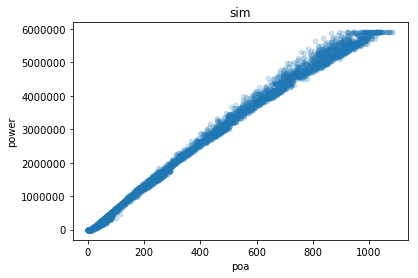

In [15]:
cptest.scatter('sim')

In [16]:
cptest.filter_irr('sim', 0, 900)
cptest.filter_irr('sim', 0.1, 900)
cptest.filter_irr('sim', 200, 900)

In [17]:
cptest.summary()

Timestamps  Timestamps_filtered     Filter_arguments
sim filter_irr        8377                  383    ('sim', 0, 900){}
    filter_irr        4124                 4253  ('sim', 0.1, 900){}
    filter_irr        2431                 1693  ('sim', 200, 900){}

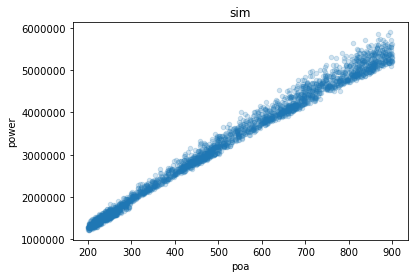

In [18]:
cptest.scatter('sim')

In [19]:
cptest.filter_time('sim', test_date='5/15/1990', days=60)

In [20]:
cptest.reg_cpt('sim', filter=True)

NOTE: Regression used to filter outlying points.


                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.725e+05
Date:                Fri, 08 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:02:16   Log-Likelihood:                -5321.5
No. Observations:                 447   AIC:                         1.065e+04
Df Residuals:                     443   BIC:                         1.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [21]:
cptest.filter_pvsyst('sim')

In [22]:
cptest.sim.df.head(1)

,GlobInc,TAmb,TArray,WindVel,FShdBm,IL Pmin,IL Vmin,IL Pmax,IL Vmax,EOutInv,E_Grid,index
date,,,,,,,,,,,,
1990-01-01,0.0,11.7,0.0,3.1,1.0,0,0,0.0,0,-1200,-8868,01/01/1990 00 00


____
#### Calculation of Reporting Conditions from PVsyst Data

In [23]:
cptest.rep_cond('sim', test_date='5/15/1990')

Reporting conditions saved to rc attribute.
{'t_amb': [27.288888888888891], 'poa': [582.69000000000005], 'w_vel': [4.4659420289855083]}


----

In [24]:
cptest.filter_irr('sim', 0.5, 1.5, ref_val=cptest.rc['poa'][0])

In [25]:
cptest.reg_cpt('sim')

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.099e+06
Date:                Fri, 08 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:02:16   Log-Likelihood:                -3581.3
No. Observations:                 318   AIC:                             7171.
Df Residuals:                     314   BIC:                             7186.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
poa             7508.0521     14.506    517.

In [26]:
cptest.summary()

Timestamps  Timestamps_filtered  \
sim filter_irr           8377                  383   
    filter_irr           4124                 4253   
    filter_irr           2431                 1693   
    filter_time           447                 1984   
    reg_cpt               414                   33   
    filter_pvsyst         414                    0   
    rep_cond              414                    0   
    filter_irr            318                   96   
    reg_cpt               318                    0   

                                                   Filter_arguments  
sim filter_irr                                    ('sim', 0, 900){}  
    filter_irr                                  ('sim', 0.1, 900){}  
    filter_irr                                  ('sim', 200, 900){}  
    filter_time      ('sim',){'test_date': '5/15/1990', 'days': 60}  
    reg_cpt                                ('sim',){'filter': True}  
    filter_pvsyst                                        ('sim',){}  
    rep_cond                     ('sim',){'test_date': '5/15/1990'}  
    filter_irr     ('sim', 0.5, 1.5){'ref_val': 582.69000000000005}  
    reg_cpt                                              ('sim',){}

_____

### Analysis of Measured Data

In [28]:
# cptest.reset_flt('das')

In [29]:
cptest.filter_sensors('das', skip_strs=['wind'])

In [30]:
cptest.filter_missing('das')

In [31]:
cptest.summary()

Timestamps  Timestamps_filtered  \
das filter_sensors         519                  921   
    filter_missing         519                    0   
sim filter_irr            8377                  383   
    filter_irr            4124                 4253   
    filter_irr            2431                 1693   
    filter_time            447                 1984   
    reg_cpt                414                   33   
    filter_pvsyst          414                    0   
    rep_cond               414                    0   
    filter_irr             318                   96   
    reg_cpt                318                    0   

                                                    Filter_arguments  
das filter_sensors                   ('das',){'skip_strs': ['wind']}  
    filter_missing                                        ('das',){}  
sim filter_irr                                     ('sim', 0, 900){}  
    filter_irr                                   ('sim', 0.1, 900){}  
    filter_irr                                   ('sim', 200, 900){}  
    filter_time       ('sim',){'test_date': '5/15/1990', 'days': 60}  
    reg_cpt                                 ('sim',){'filter': True}  
    filter_pvsyst                                         ('sim',){}  
    rep_cond                      ('sim',){'test_date': '5/15/1990'}  
    filter_irr      ('sim', 0.5, 1.5){'ref_val': 582.69000000000005}  
    reg_cpt                                               ('sim',){}

In [32]:
cptest.filter_outliers('das')

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.291691021565988 > 37.681616837732598)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.348453659198555 > 37.801979725972416)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.326621552689190 > 37.795194713615842)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.332467238505266 > 37.817724060773848)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.337811986484340 > 37.732625171098164)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.358922114208418 > 37.872822703279624)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.161924393073818 > 37.659972700564467)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.219765466670538 > 37.666696723691174)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.347093883053574 > 37.812292252601750)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.345214608280045 > 37.883309348949155)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.256095252500927 > 37.965659006230638)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.342464333030051 > 37.919566027354868)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.343036203318938 > 37.801817141656542)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.347093883053574 > 37.705955827576325)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.343621808625798 > 37.781948040351274)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.338840474211167 > 37.871254279097123)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

In [33]:
# cptest.flt_das.plot(marker='line-circle')

In [34]:
cptest.agg_sensors('das', irr='mean')

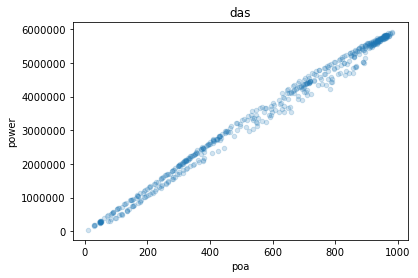

In [35]:
cptest.scatter('das')

In [36]:
cptest.reg_cpt('das', filter=True)

NOTE: Regression used to filter outlying points.


                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.472e+05
Date:                Fri, 08 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:02:17   Log-Likelihood:                -6501.5
No. Observations:                 498   AIC:                         1.301e+04
Df Residuals:                     494   BIC:                         1.303e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [37]:
cptest.summary()

Timestamps  Timestamps_filtered  \
das filter_sensors          519                  921   
    filter_missing          519                    0   
    filter_outliers         498                   21   
    reg_cpt                 478                   20   
sim filter_irr             8377                  383   
    filter_irr             4124                 4253   
    filter_irr             2431                 1693   
    filter_time             447                 1984   
    reg_cpt                 414                   33   
    filter_pvsyst           414                    0   
    rep_cond                414                    0   
    filter_irr              318                   96   
    reg_cpt                 318                    0   

                                                     Filter_arguments  
das filter_sensors                    ('das',){'skip_strs': ['wind']}  
    filter_missing                                         ('das',){}  
    filter_outliers                                        ('das',){}  
    reg_cpt                                  ('das',){'filter': True}  
sim filter_irr                                      ('sim', 0, 900){}  
    filter_irr                                    ('sim', 0.1, 900){}  
    filter_irr                                    ('sim', 200, 900){}  
    filter_time        ('sim',){'test_date': '5/15/1990', 'days': 60}  
    reg_cpt                                  ('sim',){'filter': True}  
    filter_pvsyst                                          ('sim',){}  
    rep_cond                       ('sim',){'test_date': '5/15/1990'}  
    filter_irr       ('sim', 0.5, 1.5){'ref_val': 582.69000000000005}  
    reg_cpt                                                ('sim',){}

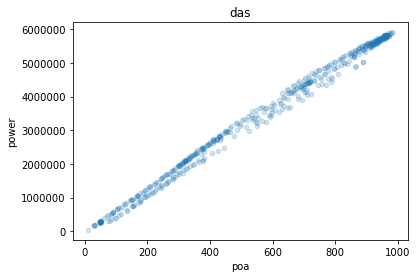

In [38]:
cptest.scatter('das')

In [39]:
cptest.filter_irr('das', 0.5, 1.5, ref_val=cptest.rc['poa'][0])

In [40]:
cptest.reg_cpt('das')

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.072e+04
Date:                Fri, 08 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:02:17   Log-Likelihood:                -3278.1
No. Observations:                 253   AIC:                             6564.
Df Residuals:                     249   BIC:                             6578.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
poa             7951.6833     94.966     83.

### Review of Significance of Regression Results

In [41]:
cptest.ols_model_das.pvalues

poa               2.240635e-184
I(poa * poa)       3.759475e-03
I(poa * t_amb)     2.232620e-40
I(poa * w_vel)     1.157744e-01
dtype: float64

In [42]:
cptest.ols_model_das.params['I(poa * w_vel)'] = 0

In [43]:
cptest.ols_model_sim.pvalues

poa                0.000000e+00
I(poa * poa)      2.354396e-174
I(poa * t_amb)    6.667244e-181
I(poa * w_vel)     1.402674e-01
dtype: float64

# Capacity Test Results

In [44]:
cptest.cp_results(6000, '+/- 5')

Capacity Test Result:         PASS
Modeled test output:          3661334.289
Actual test output:           3492289.495
Tested output ratio:          0.954
Tested Capacity:              5722.978
Bounds:                       5700.0, 6300.0
